<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install datasets

In [3]:
from datasets import load_dataset
import tensorflow as tf

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import itertools

In [9]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset

### Full Dataset 211k

In [ ]:
dataset = load_dataset("go_emotions", "raw").shuffle(seed=17)
dataset = dataset.remove_columns(['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear'])
dataset = dataset['train']

split_dataset = dataset.train_test_split(.1, seed=17)
df_train = split_dataset['train'].to_pandas()
df_test = split_dataset['test'].to_pandas()

count_train = df_train.eq(1).mean() * 100
count_test = df_test.eq(1).mean() * 100

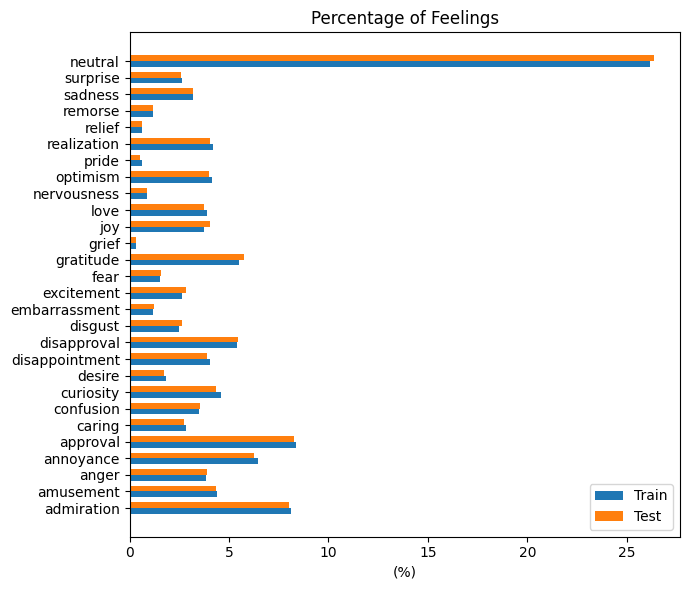

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
bar_width = 0.35
index = range(len(count_train.index[1:]))
bars_train = ax.barh(index, count_train.values[1:], bar_width, label='Train')
bars_test = ax.barh([i + bar_width for i in index], count_test.values[1:], bar_width, label='Test')
plt.yticks([i + bar_width/2 for i in index], count_train.index[1:])
plt.xlabel('(%)')
plt.title('Percentage of Feelings')
plt.legend()
plt.tight_layout()
plt.show()

### Small Dataset 54k

In [4]:
dataset_small = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset_small['train'].features['labels'].feature.names
train_small = dataset_small['train']
val_small = dataset_small['validation']
test_small = dataset_small['test']
df_train_small = dataset_small['train'].to_pandas()
df_val_small = dataset_small['validation'].to_pandas()
df_test_small = dataset_small['test'].to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [5]:
df_train_small

,text,labels,id
0,Here is their other hot wallet: the story behind,[27],eeftetq
1,Look at the spine on that kid - he must get it...,"[26, 27]",edfdgwj
2,That can be true...,[27],ee8i6sd
3,"Yeah, The Donald seems to spread its purging m...",[3],een9ehw
4,you get an upvote for that username! I wish I ...,"[0, 20]",ef7woff
...,...,...,...
43405,Yeah there's no reason to believe you staying ...,"[3, 10]",ed5aqes
43406,No lie his jumpshot is pretty If he can hit th...,[0],ef7hpoq
43407,Redditors can really come together in a time o...,"[4, 20]",efh4n6t
43408,[NAME] was horribly inconsistent this year,[14],ed16okv


In [6]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [7]:
train_freq = get_df_summary(df_train_small)
val_freq = get_df_summary(df_val_small)
test_freq = get_df_summary(df_test_small)

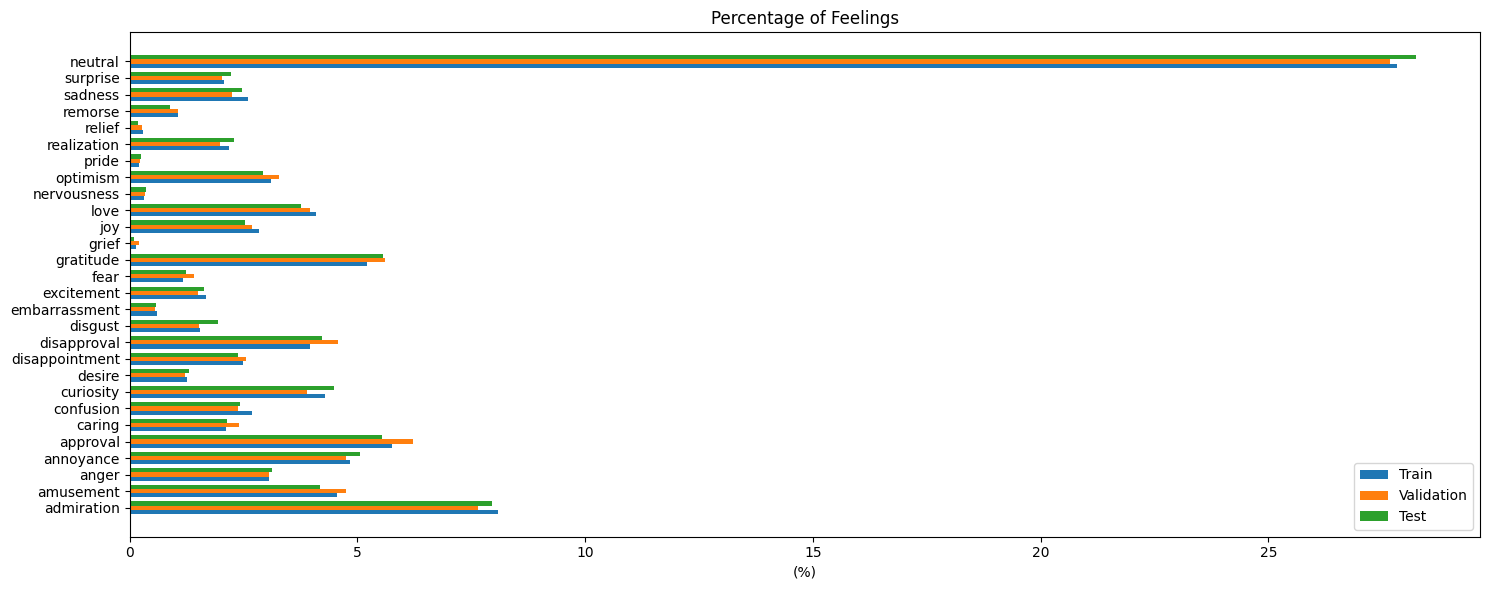

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('(%)')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

# Model

In [29]:
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# model = TFBertModel.from_pretrained('bert-base-cased')

In [183]:
pretrained_model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 28)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [160]:
pretrained_model.summary()
# for layer in model.layers[:1]:
#     layer.trainable = True

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [179]:
def tokenizer_func(text):
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf")

In [180]:
tokenized_train = list(map(tokenizer_func, train_small['text']))
tokenized_val = list(map(tokenizer_func, val_small['text']))
tokenized_test = list(map(tokenizer_func, test_small['text']))

In [181]:
tokenized_train[3]

{'input_ids': <tf.Tensor: shape=(1, 120), dtype=int32, numpy=
array([[  101,  2814,   117,  1109,  5554,  3093,  1106,  2819,  1157,
        23609, 10805,  1158,  4910,  1785,  1106,  1211,  1268,  6784,
         4841,  4359, 17903,  1116,   119, 11336, 22448,  1116,  1143,
          117,   146,  1431,  1243,  7548,  1121,   187,   120,  1103,
         2137, 24059,  1181,  1254,  1111,   186, 11848,  1916,   164,
          151, 10964,  2036,   166,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
pretrained_model()

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[0.03922055, 0.05654255, 0.02301627, 0.03310909, 0.01779182,
        0.02833208, 0.02307813, 0.03989539, 0.05587347, 0.03352971,
        0.03092371, 0.02100196, 0.01973391, 0.02104301, 0.03682394,
        0.02178124, 0.01126773, 0.03407753, 0.03884243, 0.03740072,
        0.03472467, 0.04477299, 0.04395617, 0.04930566, 0.0323837 ,
        0.06346629, 0.05078875, 0.05731658]], dtype=float32)>

In [221]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels

        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)

        # # This is to freeze the weights of the pretrained model.
        # for _ , param in self.model.named_parameters():
        #     param.requires_grad=False

        self.softmax = tf.keras.layers.Softmax()

    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)
        print(logits)
        output = self.softmax(logits[0])

        # Define a threshold to allow the model to predict more than one class.

        return output

In [222]:
model_name = "bert-base-cased"
num_labels = 28
model = BaseModel(model_name, num_labels)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [223]:
a = model(tokenized_train[0])
a

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[-0.19695637, -0.19670637,  0.1858476 ,  0.01302038,  0.7960238 ,
         0.7104153 ,  0.09157596,  0.49531567, -0.0337255 ,  0.16345465,
         0.8019391 ,  0.02545231,  0.03927881,  0.01065559,  0.26358518,
         0.31668752, -0.00273752,  0.32331645, -0.1425194 ,  0.08387832,
        -0.38833666, -0.07941359,  0.04122864, -0.85518426,  0.41529095,
         0.0546887 ,  0.1740362 ,  0.06609643]], dtype=float32)>, hidden_states=None, attentions=None)


<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[0.02473151, 0.0247377 , 0.03626605, 0.03051002, 0.06675695,
        0.06127978, 0.0330034 , 0.04941976, 0.02911662, 0.03546298,
        0.06715301, 0.03089168, 0.03132177, 0.03043795, 0.03919777,
        0.04133552, 0.03003301, 0.04161043, 0.02611514, 0.03275033,
        0.02042374, 0.02781627, 0.0313829 , 0.01280519, 0.04561906,
        0.03180818, 0.03584022, 0.03217311]], dtype=float32)>

In [224]:
b = pretrained_model(tokenized_train[0])
print(b)
tf.nn.softmax(b[0])

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[ 0.18455079,  0.51878494, -0.44418555,  0.10665362, -0.48518604,
        -0.12976305, -0.21279706,  0.14528432,  0.5946258 ,  0.05410301,
        -0.17538553, -0.25073984, -0.4161233 , -0.3302884 ,  0.15273994,
        -0.34939352, -1.1866984 ,  0.1768612 ,  0.2956785 ,  0.06823383,
         0.10383974,  0.39501593,  0.38640597,  0.4853077 , -0.01935706,
         0.6562602 ,  0.52695966,  0.46159822]], dtype=float32)>, hidden_states=None, attentions=None)


<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[0.03803391, 0.05312844, 0.02028216, 0.03518363, 0.0194674 ,
        0.02777578, 0.0255626 , 0.0365694 , 0.05731447, 0.03338245,
        0.02653705, 0.02461085, 0.02085939, 0.02272894, 0.03684306,
        0.02229882, 0.00965262, 0.03774257, 0.04250433, 0.03385752,
        0.03508477, 0.04694343, 0.04654099, 0.05137929, 0.03101808,
        0.06095815, 0.05356453, 0.05017544]], dtype=float32)>

In [177]:
import tensorflow as tf
from transformers import TFAutoModel, AutoConfig

class MyTaskSpecificCustomModel(tf.keras.Model):
    def __init__(self, checkpoint, num_labels):
        super(MyTaskSpecificCustomModel, self).__init__()
        self.num_labels = num_labels

        # Load the pre-trained model and freeze its weights
        config = AutoConfig.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True)
        self.bert = TFAutoModel.from_pretrained(checkpoint, config=config)
        self.bert.trainable = False

        # Define additional layers
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)
        self.activation1 = tf.keras.layers.Activation('tanh')
        self.activation2 = tf.keras.layers.Activation('tanh')
        self.l1 = tf.keras.layers.Dense(512)
        self.l2 = tf.keras.layers.Dense(256)
        self.l3 = tf.keras.layers.Dense(num_labels)
        self.softmax = tf.keras.layers.Softmax(axis=-1)



# Example usage:
checkpoint = "bert-base-cased"
num_labels = 10
model = MyTaskSpecificCustomModel(checkpoint, num_labels)
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)
logits = model((input_ids, attention_mask))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [175]:
np.sum(a[0])

1.1360284

In [176]:
np.sum(tf.nn.softmax(a[0]))

1.0

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)

## Trash Bin

In [ ]:
# Barplot before the split.
df = dataset.to_pandas()
counts = round(df.eq(1).mean()* 100, 2)

plt.figure(figsize=(7, 6))
plt.barh(counts.index[1:], counts.values[1:])
plt.xlabel('(%)')
plt.title('Percentage of feelings in the data')
plt.tight_layout()
plt.show()